In [1]:
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import math
import numpy as np
import time

from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from warpctc_pytorch import CTCLoss

from lib.utilities import HYPERPARAMETERS, Metric, torch_weight_init, print_model_summary, DelayedKeyboardInterrupt, \
    plot_learning_curves, visualize_data, SequenceWise
from lib.vocabulary import Vocabulary
from lib.dataloader import DataArgumentation, FromNumpyToTensor, IAMHandwritingDataset, alignCollate, ResizeAndPad
from lib.checkpoint import Checkpoint
from lib.models import CRNN
from lib.decoder import CTCGreedyDecoder
from lib.stopping import Stopping
from lib.logger import PytorchLogger, TensorboardLogger
from lib.spelling import Spelling
from lib.trainer import Trainer
from lib.evaluator import Evaluator
from lib.recognizer import Recognizer
from lib.scorer import Scorer, SpellingScorer, ScorerSM, ScorerLEV

In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
H = HYPERPARAMETERS({
    'MODEL_PATH': './chkpt/IAM_HTR_SEQ18.tar',
    'ROOT_DIR': './data',
    'EXPERIMENT': 'IAM_HTR_SEQ18',
    'BATCH_SIZE': 16,
    'HEIGHT': 64,
    'MAX_SEQ_LEN' : 93,
    'PADDING': 10,
    'NUM_WORKERS': 8,
    'ENCODER_HIDDEN_SIZE': 256,
    'DECODER_HIDDEN_SIZE': 512,
    'NUM_LAYERS': 2,
    'BIDIRECTIONAL': True,
    'RNN_DROPOUT': 0.5,
    'LR': 0.0003,
    'LR_LAMBDA': lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 11.0)), 0.4),
    'WEIGHT_DECAY': 0,
    'MAX_GRAD_NORM': 5.,
    'ARGUMENTATION': 0.9,
    'STOPPING_PATIENCE': 10,
    'NUM_EPOCHS': 20,
    
    'CHECKPOINT_FILE': 'IAM_HTR_SEQ18',
    'CHECKPOINT_INTERVAL': 5,
    'CHECKPOINT_RESTORE': False,
    
    'USE_CUDA': torch.cuda.is_available(),
})

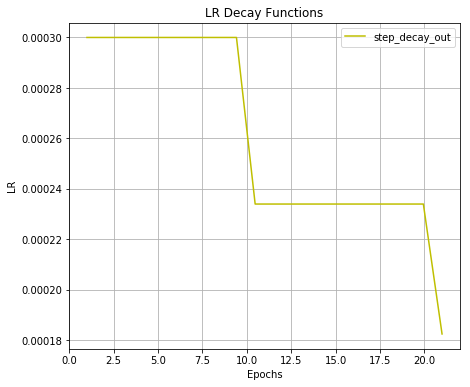

In [5]:
#https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf?

max_epochs = H.NUM_EPOCHS
epts = np.linspace(1, max_epochs+1, max_epochs)
step_decay_out = np.vectorize(H.LR_LAMBDA)(epts) * H.LR

plt.figure(figsize=(7,6))
plt.plot(epts,step_decay_out, label='step_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [6]:
import os
import json

class Vocabulary(object):
    def __init__(self, root_dir, structure='lines', architecture="ctc"):
        self.root_dir = root_dir
        self.structure = structure         # 'lines', 'words'
        self.architecture = architecture   # 'ctc', 'seq'

        self.token2idx = {}
        self.idx2token = {}
        self.idx = 0
        self.path = os.path.join(self.root_dir, 'vocab_'+ self.structure + '.json')

        if self.architecture == 'ctc':
            self.add(chr(1)) # extra output dimension for the BLANK label required for CTC loss
        else:
            self.add(chr(0)) 
            
    def add(self, token):
        if not token in self.token2idx:
            self.token2idx[token] = self.idx
            self.idx2token[self.idx] = token
            self.idx += 1

    def __call__(self, val):
        res = None
        if isinstance(val, str):
            res = self.token2idx[val] if val in self.token2idx else self.token2idx['']
        elif isinstance(val, int):
            res = self.idx2token[val] if val <= self.__len__() else self.token2idx['']
        else:
            raise RuntimeError
        return res

    def __len__(self):
        return len(self.token2idx)

    def create(self, alphabet):
        for c in alphabet:
            self.add(c)

    def dump(self):
        data = {'idx': self.idx, 'token2idx':self.token2idx, 'idx2token':self.idx2token}
        with open(self.path, "w") as fd:
            json.dump(data, fd)

    def load(self):
        with open(self.path, "r") as fd:
            data = json.load(fd)
            self.idx = int(data['idx'])
            self.token2idx = data['token2idx']
            self.idx2token = {int(k):v for k,v in data['idx2token'].items()}
            
        if self.architecture == 'seq':
            self.add('<SOS>')
            self.add('<EOS>')
            self.add('<UNK>')

    def __repr__(self):
        return ''.join(list(self.token2idx.keys()))

In [7]:
vocab = Vocabulary("./data/IAM/", structure='lines', architecture="seq")
vocab.load()

vocab, len(vocab)

(  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<SOS><EOS><UNK>,
 83)

In [8]:
import os
from glob import glob
from os.path import basename

import json
import random
import numpy as np
import re
import math

import PIL
from PIL import Image

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import tensorlayer.prepro as prepro

class IAMHandwritingDataset(data.Dataset):
    """IAM Handwriting Database ( http://www.fki.inf.unibe.ch/databases/iam-handwriting-database )"""

    def __init__(self, root, vocab, dataset, structure, 
                 transform=None, target_transform=None, max_size=None):
        self.root = root
        self.vocab = vocab
        self.dataset = dataset
        self.structure = structure         # 'lines', 'words'
        self.transform = transform
        self.target_transform = target_transform
        self.max_size = max_size


        self.annotations = []
        self.max_seq_length = 0
        self.index = []

        self.annotations, self.max_seq_length = self.load_annotations(self.root, self.dataset, 
                                                                      self.structure)
        self.index = self.load_index(self.root, structure)

        if isinstance(self.max_size, int):

            assert self.max_size < len(self.annotations) # max_train_size needs to select a subset

            self.annotations = random.sample(self.annotations, self.max_size)

    def __getitem__(self, index):
        annotation = self.annotations[index]
        anid = annotation['anid']
        path = self.index[anid]

        image = Image.open(path).convert('L')
        if self.transform is not None:
            image = self.transform(image)

        target = annotation['transcript']
        if vocab.architecture == 'seq':
            target = [self.vocab("<SOS>")] + [self.vocab(token) for token in target] + [self.vocab('<EOS>')]
        else:
            target = [self.vocab(token) for token in target]
        target = np.array(target)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.annotations)

    @classmethod
    def create(cls, root, structure='lines', partition='aachen'):
        path = os.path.join(root, 'part', structure, partition, 'tr.txt')
        with open(path, 'r') as infile:
            trainset = {v.strip() for v in infile.readlines()}

        try:
            path = os.path.join(root, 'part', structure, partition, 'va.txt')
            with open(path , 'r') as infile:
                validationset1 = {v.strip() for v in infile.readlines()}
                validationset2 = {}
        except:
            try:
                path = os.path.join(root, 'part', structure, partition, 'va1.txt')
                with open(path , 'r') as infile:
                    validationset1 = {v.strip() for v in infile.readlines()}
                
                path = os.path.join(root, 'part', structure, partition, 'va2.txt')
                with open(path, 'r') as infile:
                    validationset2 = {v.strip() for v in infile.readlines()}
            except:
                raise RuntimeError('Dataset files not found.')

        path = os.path.join(root, 'part', structure, partition, 'te.txt')
        with open(path, 'r') as infile:
            testset = {v.strip() for v in infile.readlines()}
            
        file_index = cls.load_index(root, structure)

        path = os.path.join(root, 'ascii', structure + '.txt')

        annotations = []
        max_seq_length = 0
        with open(path, "r") as fd:
            for idx, line in enumerate(fd.readlines()):
                if '#' in line[0]:
                    continue
                fields = line.rstrip().split(" ")

                transcript = fields[8]
                # transcript field has whitespaces in it - need to fix the erroneous splits
                if len(fields) > 9:
                    for i in range(9, len(fields)):
                        transcript += fields[i]

                if structure == 'lines':
                    # replace | seperator with whitespace
                    transcript = transcript.replace("|", " ")

                l = len(transcript)
                if not l:
                    continue

                if l > max_seq_length:
                    max_seq_length = l

                if structure == 'lines':
                    annotation={
                        'anid': fields[0],
                        'seg_result': fields[1],
                        'graylevel': fields[2],
                        'components': fields[3],
                        'bounding_box':[fields[4], fields[5], fields[6], fields[7]],
                        'transcript': transcript
                    }
                else:
                    annotation={
                        'anid': fields[0],
                        'seg_result': fields[1],
                        'graylevel': fields[2],
                        'bounding_box':[fields[3], fields[4], fields[5], fields[6]],
                        'tag': fields[7],
                        'transcript': transcript
                    }
                    
                anid = annotation['anid']
                
                try:
                    path = file_index[anid]
                    _ = Image.open(path)
                except (IOError, KeyError):
                    print('Corrupted image for %s ' % path)
                    continue

                if not anid in file_index:
                    print('File missing %s' % path)
                    continue

                if structure == 'words':                                
                    anid = annotation['anid'][:-3]
                    
                if anid in trainset:
                    dataset = "train"
                elif anid in validationset1:
                    dataset = "valid1"
                elif anid in validationset2:
                    dataset = "valid2"
                elif anid in testset:
                    dataset = "test"
                else:
                    dataset = "train"
                
                annotation['dataset'] = dataset

                annotations.append(annotation)

        path = os.path.join(root, 'annotations_'+ structure + '.json')

        with open(path, 'w') as outfile:
            json.dump({'annotations': annotations,
                       'max_seq_length': max_seq_length},
                      outfile)

    @classmethod
    def load_annotations(cls, root, dataset, structure):
        path = os.path.join(root, 'annotations_'+ structure + '.json')

        with open(path, "r") as fd:
            content = json.load(fd)

        if not len(content):
            raise RuntimeError('Dataset empty.')

        annotations = content['annotations']
        max_seq_length = content['max_seq_length']

        if "train" in dataset:
            annotations = [a for a in annotations if 'train' in a['dataset']]
        elif "valid" in dataset:
            annotations = [a for a in annotations if 'valid1' in a['dataset'] or 'valid2' in a['dataset']]
        elif "test" in dataset:
            annotations = [a for a in annotations if 'test' in a['dataset']]
        else:
            raise RuntimeError('Dataset parameter can be: "train", "valid" or "test".')

        return annotations, max_seq_length

    @classmethod
    def load_index(cls, root, structure):
        extension = 'jpg' #if 'lines' in structure else '.png'
        path = os.path.join(root, 'imgs', structure)
                
        files = []
        for root, dirs, flst in os.walk(path):
            for file in flst:
                if file.endswith(extension):
                    files.append(os.path.join(root, file))

        index = dict([(basename(path).rstrip("." + extension) , path) for path in files])

        if not len(index):
            raise RuntimeError('Image files empty.')
        return index

    def __repr__(self):
        fmt_str = self.__class__.__name__ + '\n'
        fmt_str += '    Number of images found: {}\n'.format(len(self.index))
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str
    

In [9]:
# IAMHandwritingDataset.create('./data/IAM/', structure='words', partition='original')
# vocab = Vocabulary("./data/IAM/", structure='words', architecture="seq")
# train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train", structure='words')
# len(train_dataset.annotations[0]['transcript'])
# train_dataset.annotations[0]['transcript']
# d = {}
# for ann in train_dataset.annotations:
#     for c in ann['transcript']:
#         d[c] = 1 if not c in d else d[c] + 1
# vocab.create(sorted(list(d.keys())))
# vocab.dump()

In [10]:
# IAMHandwritingDataset.create('./data/IAM/', structure='lines', partition='aachen')
# vocab = Vocabulary("./data/IAM/", structure='lines', architecture="seq")
# train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train", structure='lines')
# len(train_dataset.annotations[0]['transcript'])
# train_dataset.annotations[0]['transcript']
# d = {}
# for ann in train_dataset.annotations:
#     for c in ann['transcript']:
#         d[c] = 1 if not c in d else d[c] + 1
# vocab.create(sorted(list(d.keys())))
# vocab.dump()

In [11]:
image_transform_train = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
#     DataArgumentation(threshold=H.ARGUMENTATION),
    transforms.ToTensor(),
])

image_transform_test = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    FromNumpyToTensor()
])

In [12]:
train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train", structure="lines",
                                      #max_size=10000,
                                     transform=image_transform_train, target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=H.BATCH_SIZE, num_workers=H.NUM_WORKERS, shuffle=True,
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

train_dataset, len(train_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 9472
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb90b8>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb9710>,
 592)

In [13]:
H.MAX_SEQ_LEN = train_dataset.max_seq_length
H.MAX_SEQ_LEN

93

In [14]:
valid_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="valid", structure="lines",
                                      #max_size=200,
                                     transform=image_transform_test, target_transform=target_transform)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS, 
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

valid_dataset, len(valid_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 966
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb9208>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb9710>,
 61)

In [15]:
test_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="test", structure="lines", 
                                     transform=image_transform_test, target_transform=target_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS,
    collate_fn=alignCollate(img_height=H.HEIGHT))

test_dataset, len(test_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 2915
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb9208>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1b9bb9710>,
 183)

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

input_vars, target_vars, input_sizes, target_len = next(train_loader.__iter__())

print(input_vars.shape, target_vars.shape)

@interact(idx=(0, H['BATCH_SIZE']-1))
def show(idx):
    print(input_vars[idx].shape)
    visualize_data(input_vars[idx], target_vars[idx], vocab, figsize=(18,8))

torch.Size([16, 1, 64, 1259]) torch.Size([16, 65])


interactive(children=(IntSlider(value=7, description='idx', max=15), Output()), _dom_classes=('widget-interact',))

In [17]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [18]:
class CNN(nn.Module):
    def __init__(self, initialize=None):
        super(CNN, self).__init__()
        self.initialize = initialize
        self.inplanes = 32

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 0)),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.bb1 = self._make_layer(BasicBlock, 64, 2)
        self.maxpoo11 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.dropout1 = nn.Dropout(0.5)

        self.bb2 = self._make_layer(BasicBlock, 128, 2)
        self.maxpoo12 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.dropout2 = nn.Dropout(0.5)

        self.bb3 = self._make_layer(BasicBlock, 256, 2)
        self.maxpoo13 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.dropout3 = nn.Dropout(0.5)

        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 0)),
            nn.Dropout(0.5)
        )
        
        if not self.initialize is None:
            self.initialize(self)

    def forward(self, input_vars):
        conv = self.conv1(input_vars)
        conv = self.bb1(conv)
        conv = self.maxpoo11(conv)
        conv = self.dropout1(conv)
        conv = self.bb2(conv)
        conv = self.maxpoo12(conv)
        conv = self.dropout2(conv)
        conv = self.bb3(conv)
        conv = self.maxpoo13(conv)
        conv = self.dropout3(conv)
        conv = self.conv2(conv)
        return conv.squeeze(2)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)

In [19]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=128, n_layers=1, dropout=0, initialize=None, 
                 bidirectional=True):
        super(Encoder,self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.initialize = initialize
        self.bidirectional = bidirectional
        self.input_size = 256
        
        self.cnn = CNN(initialize=self.initialize)
        
        self.rnn = nn.GRU(self.input_size, self.hidden_size, self.n_layers, batch_first=True, dropout=self.dropout,
                         bidirectional=self.bidirectional)
        
        if not self.initialize is None:
            self.initialize(self)

    def forward(self, input_vars, hidden):
 
        internal_vars = self.cnn(input_vars)

        internal_vars = internal_vars.transpose(1,2)

        output_vars, hidden = self.rnn(internal_vars, hidden)
        
        output_vars = self._sum_outputs(output_vars)
        
        hidden = self._cat_hidden(hidden)
        
        return output_vars, hidden


    def _cat_hidden(self, h):
        """ 
        (#directions * #layers, #batch, hidden_size) -> (#layers, #batch, #directions * hidden_size)
        """
        if self.bidirectional:
            h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
        return h
    
    def _sum_outputs(self, outputs):
        # sum bidirectional outputs
        if self.bidirectional:
            outputs = (outputs[:, :, :self.hidden_size] +
                       outputs[:, :, self.hidden_size:])
        return outputs

    def initHidden(self,batch_size,use_cuda=False):
        m = 2 if self.bidirectional else 1
        h0 = Variable(torch.zeros(self.n_layers * m, batch_size, self.hidden_size))
        if use_cuda:
            return h0.cuda()
        else:
            return h0

In [20]:
encoder_cpu = Encoder(H.ENCODER_HIDDEN_SIZE, n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, 
                      initialize=torch_weight_init, bidirectional=H.BIDIRECTIONAL)

hidden_cpu = encoder_cpu.initHidden(1, use_cuda=False)

encoder_outputs_cpu, encoder_hidden_cpu = encoder_cpu(input_vars[0:1], hidden_cpu)

# print_model_summary(encoder_cpu)
# print(encoder_cpu)

input_vars.shape, hidden_cpu.shape, encoder_outputs_cpu.shape, encoder_hidden_cpu.shape

(torch.Size([16, 1, 64, 1259]),
 torch.Size([4, 1, 256]),
 torch.Size([1, 154, 256]),
 torch.Size([2, 1, 512]))

In [21]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, initialize=None):
        super(Attention, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.initialize = initialize
        self.mode = 'non_linear' # 'dot' , 'linear', 'non_linear'
        
        
        if self.mode == 'dot':
            pass
        elif self.mode == 'linear':
            self.fc = nn.Linear(self.encoder_hidden_size, self.encoder_hidden_size, 
                                        bias=False)
        elif self.mode == 'non_linear':
            self.fc1 = nn.Linear(self.decoder_hidden_size, self.encoder_hidden_size,bias=False)
            self.fc2 = nn.Linear(self.encoder_hidden_size, 1, bias=False)
        else:
            raise NotImplementedError

        self.linear_out = nn.Linear(self.decoder_hidden_size, self.encoder_hidden_size)
        self.mask = None
        
        if not self.initialize is None:
            self.initialize(self)

    def set_mask(self, mask):
        self.mask = mask
        
    def forward(self, output, context):
        batch_size = output.size(0)
        input_size = context.size(1)
        
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        
        if self.mode == 'dot':
            attn = torch.bmm(output, context.transpose(1, 2))
        elif self.mode == 'linear':
            output = self.fc(output)
            attn = torch.bmm(output, context.transpose(1, 2))
        elif self.mode == 'non_linear':
            out_expanded = output.squeeze(0).expand_as(context.squeeze(0))
            energy = torch.cat((context, out_expanded), 2)
            energy = torch.tanh(self.fc1(energy))
            attn = self.fc2(energy).transpose(1, 2)
        else:
            raise NotImplementedError
                
        if self.mask is not None:
            attn.data.masked_fill_(self.mask, -float('inf'))
        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)

        # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        mix = torch.bmm(attn, context)

        # concat -> (batch, out_len, 2*dim)
        combined = torch.cat((mix, output), dim=2)
        # output -> (batch, out_len, dim)
        output = self.linear_out(combined.view(-1, self.decoder_hidden_size))
        output = torch.tanh(output).view(batch_size, -1, self.encoder_hidden_size)

        return output

In [22]:
class Decoder(nn.Module):
    def __init__(self, input_vocab_size, decoder_hidden_size, encoder_hidden_size, 
                 output_size, n_layers=1, dropout=0.0, initialize=None):
        super(Decoder, self).__init__()
        self.input_vocab_size = input_vocab_size
        self.decoder_hidden_size = decoder_hidden_size
        self.encoder_hidden_size = encoder_hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.initialize = initialize
        
        self.embedding = nn.Sequential(
            nn.Embedding(self.input_vocab_size, self.decoder_hidden_size),
            nn.Dropout(0.5)
        )
        
        self.attn = Attention(self.encoder_hidden_size, self.decoder_hidden_size, self.initialize)

        self.rnn = nn.GRU(self.decoder_hidden_size, self.decoder_hidden_size, 
                          self.n_layers, batch_first=True, dropout=self.dropout)

        self.fc = nn.Linear(self.encoder_hidden_size, self.output_size)
        
        if not self.initialize is None:
            self.initialize(self)

        fix_embedding = torch.from_numpy(np.eye(self.input_vocab_size, self.input_vocab_size).astype(np.float32))
        self.embedding.weight = nn.Parameter(fix_embedding)
        self.embedding.weight.requires_grad=False

    def forward(self, input_vars, last_hidden, encoder_outputs):
        
        batch_size = input_vars.size(0)
        output_size = input_vars.size(1)
        
        embedding_input = self.embedding(input_vars)
                              
        output, hidden = self.rnn(embedding_input, last_hidden)
                        
        output = output[:, :, :self.encoder_hidden_size] + output[:, :, self.encoder_hidden_size :]
        
        output = self.attn(output, encoder_outputs)
        
        output = self.fc(output.contiguous().view(-1, self.encoder_hidden_size))
        
        output = F.log_softmax(output, dim=1).view(batch_size, output_size, -1)
        
        return output, hidden
    

In [23]:
decoder_cpu = Decoder(len(vocab), H.DECODER_HIDDEN_SIZE, H.ENCODER_HIDDEN_SIZE, len(vocab), 
                      n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, 
                      initialize=torch_weight_init)

decoder_cpu.train()
# decoder_output_cpu, hidden_cpu, = decoder_cpu(target_vars, encoder_hidden_cpu, 
#                                              encoder_outputs_cpu)

# # print_model_summary(decoder_cpu)

# target_vars.shape, encoder_hidden_cpu.shape, encoder_outputs_cpu.shape, decoder_output_cpu.shape, hidden_cpu.shape


Decoder(
  (embedding): Sequential(
    (0): Embedding(83, 512)
    (1): Dropout(p=0.5)
  )
  (attn): Attention(
    (fc1): Linear(in_features=512, out_features=256, bias=False)
    (fc2): Linear(in_features=256, out_features=1, bias=False)
    (linear_out): Linear(in_features=512, out_features=256, bias=True)
  )
  (rnn): GRU(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=83, bias=True)
)

In [24]:
class NeuralHandwrittenTextRecognizer(nn.Module):
    def __init__(self, encoder, decoder, vocab, teacher_forcing_ratio=0.5):
        super(NeuralHandwrittenTextRecognizer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab = vocab
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, input_var, target_var):
        use_cuda = next(self.parameters()).is_cuda
        batch_size = input_var.size(0)
        max_length = target_var.size(1) if not target_var is None else H.MAX_SEQ_LEN + 2

        init_hidden = self.encoder.initHidden(batch_size, use_cuda=use_cuda)
        encoder_outputs, encoder_hidden = self.encoder(input_var, init_hidden)
                
        decoder_input = Variable(torch.LongTensor([self.vocab("<SOS>")] * batch_size)).view(batch_size, 1)
        if use_cuda:
            decoder_input = decoder_input.cuda()
        
        decoder_hidden = encoder_hidden

        decoder_outputs = []
        for di in range(max_length-1):

            decoder_output, decoder_hidden = self.decoder(decoder_input, 
                                                                decoder_hidden, 
                                                                encoder_outputs)
     
            step_output = decoder_output.squeeze(1)
            decoder_outputs.append(step_output)

            use_teacher_forcing = True if self.training and random.random() < self.teacher_forcing_ratio else False       
            if use_teacher_forcing:
                decoder_input = Variable(target_var.data[:, di+1]).view(batch_size, 1)
            else:
                decoder_input = Variable(decoder_outputs[-1].topk(1)[1].data).view(batch_size, 1)
            if next(self.parameters()).is_cuda:
                decoder_input = decoder_input.cuda()
                
        return decoder_outputs

In [25]:
nhtr_cpu = NeuralHandwrittenTextRecognizer(encoder_cpu, decoder_cpu, vocab, teacher_forcing_ratio=0.5)

nhtr_cpu.train()
result_cpu = nhtr_cpu(input_vars, target_vars)

# print_model_summary(nhtr_cpu)
# print(nhtr_cpu)

input_vars.shape, target_vars.shape, result_cpu[0].shape

(torch.Size([16, 1, 64, 1259]), torch.Size([16, 65]), torch.Size([16, 83]))

In [26]:
def eos_parsing(sentence, vocab):
    IDX_EOS = vocab('<EOS>')
    if IDX_EOS in sentence:
        sentence = sentence[:sentence.index(IDX_EOS)]
    return sentence

def get_perplexity(loss):
    try:
        return math.pow(2, loss)
    except OverflowError:
        return float('inf')

In [27]:
import Levenshtein as lev
from difflib import SequenceMatcher

def accuracy_score(decoder_outputs, target_variables):
    batch_size = target_variables.size(0)

    output_seq = [[] for _ in range(batch_size)]
    for decoder_output in decoder_outputs:
        for batch_idx in range(batch_size):
            output_seq[batch_idx].append(decoder_output[batch_idx].topk(1)[1].item())

    target_seq = [[] for _ in range(batch_size)]
    for batch_idx in range(batch_size):
        target_seq[batch_idx] = [i.item() for i in target_variables[batch_idx]][1:-1]

    for batch_idx in range(batch_size):
        output_seq[batch_idx] = eos_parsing(output_seq[batch_idx], vocab)
        target_seq[batch_idx] = eos_parsing(target_seq[batch_idx], vocab)
  
    idx, acc, cer = 0, 0.0, 0.0
    for idx, (dseq, tseq) in enumerate(zip(output_seq, target_seq)):
        dseq = ''.join([vocab(c) for c in dseq])
        tseq = ''.join([vocab(c) for c in tseq])

        acc += SequenceMatcher(None, dseq, tseq).ratio()
        cer += lev.distance(dseq, tseq) / float(len(tseq))

    return acc / (idx + 1), cer / (idx + 1)

In [28]:
m = Metric([('train_loss', np.inf), ('train_score', np.inf), ('valid_loss', np.inf), ('valid_score', 0), 
            ('train_lr', 0), ('valid_ppl', np.inf), ('valid_cer', np.inf)]) 

encoder = Encoder(H.ENCODER_HIDDEN_SIZE, n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, 
                  bidirectional=H.BIDIRECTIONAL, initialize=torch_weight_init)

decoder = Decoder(len(vocab), H.DECODER_HIDDEN_SIZE, H.ENCODER_HIDDEN_SIZE, len(vocab), 
                  n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, initialize=torch_weight_init)

nhtr = NeuralHandwrittenTextRecognizer(encoder, decoder, vocab, teacher_forcing_ratio=0.5)
if H.USE_CUDA:
    nhtr.cuda()

path = './chkpt/IAM_HTR_SEQ8_CNN.tar'
state = torch.load(path)
nhtr.encoder.cnn.load_state_dict(state)
for param in nhtr.encoder.cnn.parameters():
    param.requires_grad = False
    
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(filter(lambda p:p.requires_grad, nhtr.parameters())),
                        amsgrad = False,
                        betas = (0.9, 0.999),
                        eps = 1e-08,
                        lr = H.LR,
                        weight_decay = H.WEIGHT_DECAY)

stopping = Stopping(nhtr, patience= H.STOPPING_PATIENCE)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[H.LR_LAMBDA])

logger = TensorboardLogger(experiment_dir=H.EXPERIMENT) #PytorchLogger()

checkpoint = Checkpoint(nhtr, optimizer, stopping, m, experiment_dir=H.EXPERIMENT, checkpoint_file=H.CHECKPOINT_FILE,
                         restore_from=-1, interval=H.CHECKPOINT_INTERVAL, verbose=0)

In [29]:
epoch_start = checkpoint.restore()+1 if H.CHECKPOINT_RESTORE else 1
epoch_itr = logger.set_itr(range(epoch_start, H.NUM_EPOCHS+1))

epoch = 0
for epoch in epoch_itr:

    nhtr.train(True)

    scheduler.step(epoch)
    
    m.train_lr = [float(param_group['lr']) for param_group in optimizer.param_groups][0]
    
    idx_batch, avg_loss = 0, 0.0
    for idx_batch,(input_variables, target_variables, input_size, target_size) in enumerate(train_loader):
        input_variables, target_variables = Variable(input_variables), Variable(target_variables)
        if H.USE_CUDA:
            input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

        decoder_outputs = nhtr(input_variables, target_variables)
        
        loss = 0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            out_batch_size = target_variables.size(0)                        
            loss += criterion(seq_output.contiguous().view(out_batch_size, -1), target_variables[:, idx_seq + 1])
        
        avg_loss += loss.item() / (idx_seq + 1)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nhtr.parameters(), H.MAX_GRAD_NORM)
        optimizer.step()
        
        del decoder_outputs
        del loss
                        
    m.train_loss = avg_loss / (idx_batch + 1)
    
    ######## validation

    nhtr.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
    with torch.no_grad():
        
        idx_batch, avg_loss, avg_score, avg_cer = 0, 0.0, 0.0, 0.0
        for idx_batch,(input_variables, target_variables, input_size, target_size) in enumerate(valid_loader):
            input_variables, target_variables = Variable(input_variables), Variable(target_variables)
            if H.USE_CUDA:
                input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

            decoder_outputs = nhtr(input_variables, None)
            batch_size = target_variables.size(0)
            max_len = target_variables.size()[1]

            loss, score = 0.0, 0.0
            target_length = target_variables.size(1) - 1
            for idx_seq in range(target_length):
                seq_output = decoder_outputs[idx_seq]
                out_batch_size = target_variables.size(0)                        
                loss += criterion(seq_output.contiguous().view(out_batch_size, -1), target_variables[:, idx_seq + 1])
                        
            avg_loss += loss.item() / (idx_seq + 1)
            acc, cer = accuracy_score(decoder_outputs, target_variables)
            avg_score += acc
            avg_cer += cer

            del decoder_outputs
            del loss
            
        m.valid_loss = avg_loss / (idx_batch + 1)
        m.valid_ppl = get_perplexity(m.valid_loss)
        m.valid_score = avg_score / (idx_batch + 1)
        m.valid_cer = avg_cer / (idx_batch + 1)
        
    if checkpoint:
        checkpoint.step(epoch)

    stopping_flag = stopping.step(epoch, m.valid_loss, m.valid_score)

    epoch_itr.log_values( m.train_loss, m.train_score, m.train_lr, m.valid_loss, m.valid_score,
                      stopping.best_score_epoch, stopping.best_score)
    
    if stopping_flag:
        print("Early stopping at epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))
        break

checkpoint.create(epoch)

{'ARGUMENTATION': 0.9,
 'BATCH_SIZE': 16,
 'BIDIRECTIONAL': True,
 'CHECKPOINT_FILE': 'IAM_HTR_SEQ18',
 'CHECKPOINT_INTERVAL': 5,
 'CHECKPOINT_RESTORE': False,
 'DECODER_HIDDEN_SIZE': 512,
 'ENCODER_HIDDEN_SIZE': 256,
 'EXPERIMENT': 'IAM_HTR_SEQ18',
 'HEIGHT': 64,
 'LR': 0.0003,
 'LR_LAMBDA': <function __main__.<lambda>>,
 'MAX_GRAD_NORM': 5.0,
 'MAX_SEQ_LEN': 93,
 'MODEL_PATH': './chkpt/IAM_HTR_SEQ18.tar',
 'NUM_EPOCHS': 20,
 'NUM_LAYERS': 2,
 'NUM_WORKERS': 8,
 'PADDING': 10,
 'RNN_DROPOUT': 0.5,
 'ROOT_DIR': './data',
 'STOPPING_PATIENCE': 10,
 'USE_CUDA': True,
 'WEIGHT_DECAY': 0}

TensorboardLogger
    Last Epoch/LR:    20 / 0.000234
    Train Loss/Score: 0.16012168352033485 / inf
    Valid Loss/Score: 1.5868971166595374 / 0.9389474401861874
    Best Epoch/Score: 15 / 0.9521214837335633

Stopping
    Patience: 10
    Best Score: 0.9521
    Epoch of Best Score: 15

Checkpoint
    Timestamp: 2019_02_05_19_00_09
    Last Checkpoint: chkpt/IAM_HTR_SEQ18/2019_02_05_19_00_09/state.tar



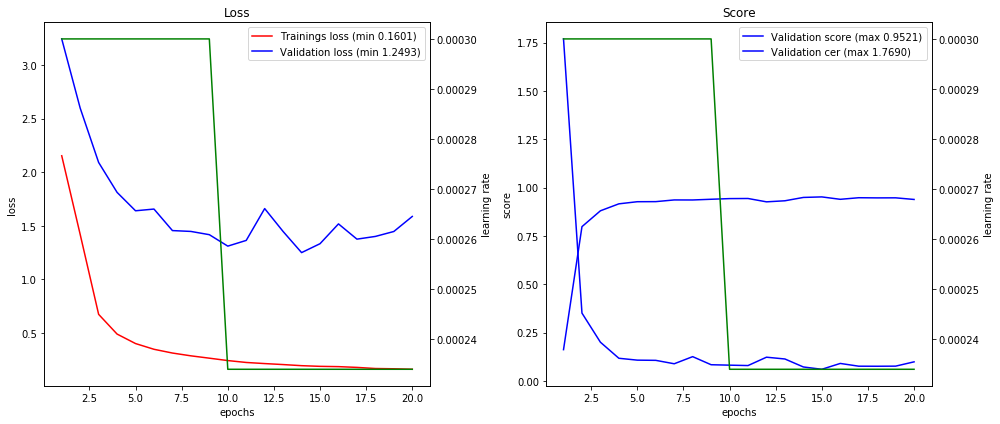

In [30]:
display(H)
print(logger)
print(stopping)
print(checkpoint)
plot_learning_curves(m)

In [31]:
nhtr.load_state_dict(stopping.best_score_state)
torch.save(nhtr.state_dict(), H.MODEL_PATH)

In [32]:
from nltk.translate.bleu_score import sentence_bleu
import Levenshtein as lev

class Scorer(object):
    def __init__(self):
        pass
    
    @staticmethod
    def wer(s1, s2):
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]
        return lev.distance(''.join(w1), ''.join(w2)) 

    @staticmethod
    def cer(s1, s2):
        s1, s2, = s1.replace(' ', ''), s2.replace(' ', '')
        return lev.distance(s1, s2) 
    
    def score(self,predicted_vars, target_vars):
        idx, acc, cer = 0, 0.0, 0.0
        for idx, (dseq, tseq) in enumerate(zip(predicted_vars, target_vars)):
#           acc = acc + 1 if dseq == tseq else acc
#             acc += fuzz.ratio(tseq, dseq)
#             acc += SequenceMatcher(None, dseq, tseq).ratio()
#             acc += sentence_bleu([tseq], dseq, emulate_multibleu=True)
            acc += self.wer(dseq, tseq) / float(len(tseq.split()))
            cer += self.cer(dseq, tseq) / float(len(tseq))

        return (acc / (idx + 1)), cer / (idx + 1)
    
scorer = Scorer()

In [33]:
encoder_pred = Encoder(H.ENCODER_HIDDEN_SIZE, n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, 
                  bidirectional=H.BIDIRECTIONAL, initialize=torch_weight_init)
decoder_pred = Decoder(len(vocab), H.DECODER_HIDDEN_SIZE, H.ENCODER_HIDDEN_SIZE, len(vocab), 
                  n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, initialize=torch_weight_init)
nhtr_pred = NeuralHandwrittenTextRecognizer(encoder_pred, decoder_pred, vocab, teacher_forcing_ratio=0.5)
if H.USE_CUDA:
    nhtr_pred.cuda()
    
state = torch.load(H.MODEL_PATH)
nhtr_pred.load_state_dict(state)

In [34]:
%%time
nhtr_pred.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
with torch.no_grad():

    idx_batch, avg_loss, avg_score, avg_ppl, avg_cer = 0, 0.0, 0.0, 0.0, 0.0
    for idx_batch,(input_variables, target_variables, input_size, target_size) in enumerate(test_loader):
        input_variables, target_variables = Variable(input_variables), Variable(target_variables)
        if H.USE_CUDA:
            input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

        decoder_outputs = nhtr_pred(input_variables, None)
        batch_size = target_variables.size(0)
        max_len = target_variables.size()[1]

        loss, score = 0.0, 0.0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            loss += criterion(seq_output.contiguous(), target_variables[:, idx_seq + 1])

        avg_loss += loss.item() / (idx_seq + 1)
        acc, cer = accuracy_score(decoder_outputs, target_variables)
        avg_score += acc
        avg_cer += cer
        
        del decoder_outputs
        del loss
               
    avg_loss = avg_loss / (idx_batch + 1)
    avg_ppl = get_perplexity(m.valid_loss)
    avg_score = avg_score / (idx_batch + 1)
    avg_cer = avg_cer / (idx_batch + 1)

    
print('Test Results:')
print('     Loss:           {:.4f}'.format(avg_loss))
print('     Accuracy:       {:.4f}'.format(avg_score))
print('     CER:            {:.4f}'.format(avg_cer))
print('     PPL:            {:.4f}'.format(avg_ppl))

Test Results:
     Loss:           2.0772
     Accuracy:       0.9114
     CER:            0.1410
     PPL:            3.0040
CPU times: user 58.8 s, sys: 666 ms, total: 59.5 s
Wall time: 59.7 s


In [35]:
nhtr_pred.eval()
with torch.no_grad():
    idx_batch = 0
    bad_lines = []
    for idx_batch,(input_vars, target_vars, input_size, target_size) in enumerate(test_loader):
        input_vars = Variable(input_vars)
        if H.USE_CUDA:
            input_vars = input_vars.cuda()

        decoder_outputs = nhtr_pred(input_vars, None)

        batch_size = target_variables.size(0)

        output_seq = [[] for _ in range(batch_size)]
        for decoder_output in decoder_outputs:
            for batch_idx in range(batch_size):
                output_seq[batch_idx].append(decoder_output[batch_idx].topk(1)[1].item())

        target_seq = [[] for _ in range(batch_size)]
        for batch_idx in range(batch_size):
            target_seq[batch_idx] = [i.item() for i in target_vars[batch_idx]][1:-1]

        for batch_idx in range(batch_size):
            output_seq[batch_idx] = eos_parsing(output_seq[batch_idx], vocab)
            target_seq[batch_idx] = eos_parsing(target_seq[batch_idx], vocab)
                    
        idx = 0
        for idx, (dseq, tseq) in enumerate(zip(output_seq, target_seq)):
            dseq = ''.join([vocab(c) for c in dseq])
            tseq = ''.join([vocab(c) for c in tseq])   
            if dseq != tseq:
                bad_lines.append((input_vars[idx], dseq, tseq))
                    
len(bad_lines)

452

94 9


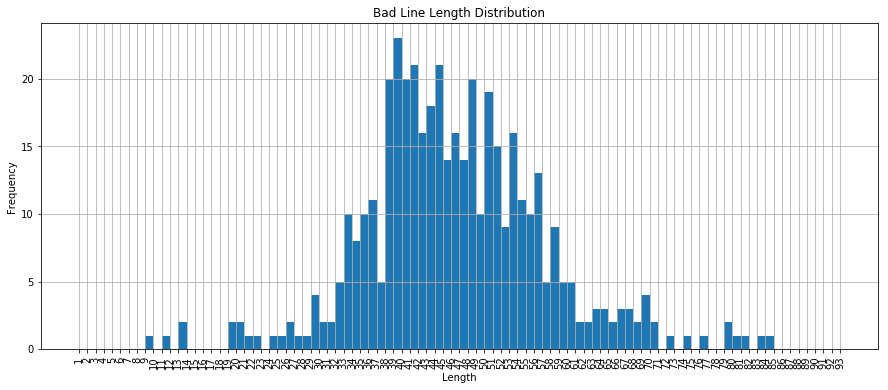

In [36]:
import matplotlib.mlab as mlab

line_len = sorted([len(l[1]) for l in bad_lines], reverse=True)
print(max(line_len), min(line_len))

if max(line_len):
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(range(1, max(line_len)))

    ax = plt.hist(line_len, bins=range(1, max(line_len)))

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title("Bad Line Length Distribution")
    plt.xticks(rotation=90)
    plt.grid(True)

In [37]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(idx=(0, len(bad_lines)-1))
def show(idx):
    img = bad_lines[idx][0]
    dseq = bad_lines[idx][1]
    tseq = bad_lines[idx][2]
    visualize_data(img, tseq + "==" + dseq + "=" + str(tseq==dseq), vocab, figsize=(18,8))

interactive(children=(IntSlider(value=225, description='idx', max=451), Output()), _dom_classes=('widget-interact',))